# Plot used in Paper ###

Number of non-numeric ratings: 0


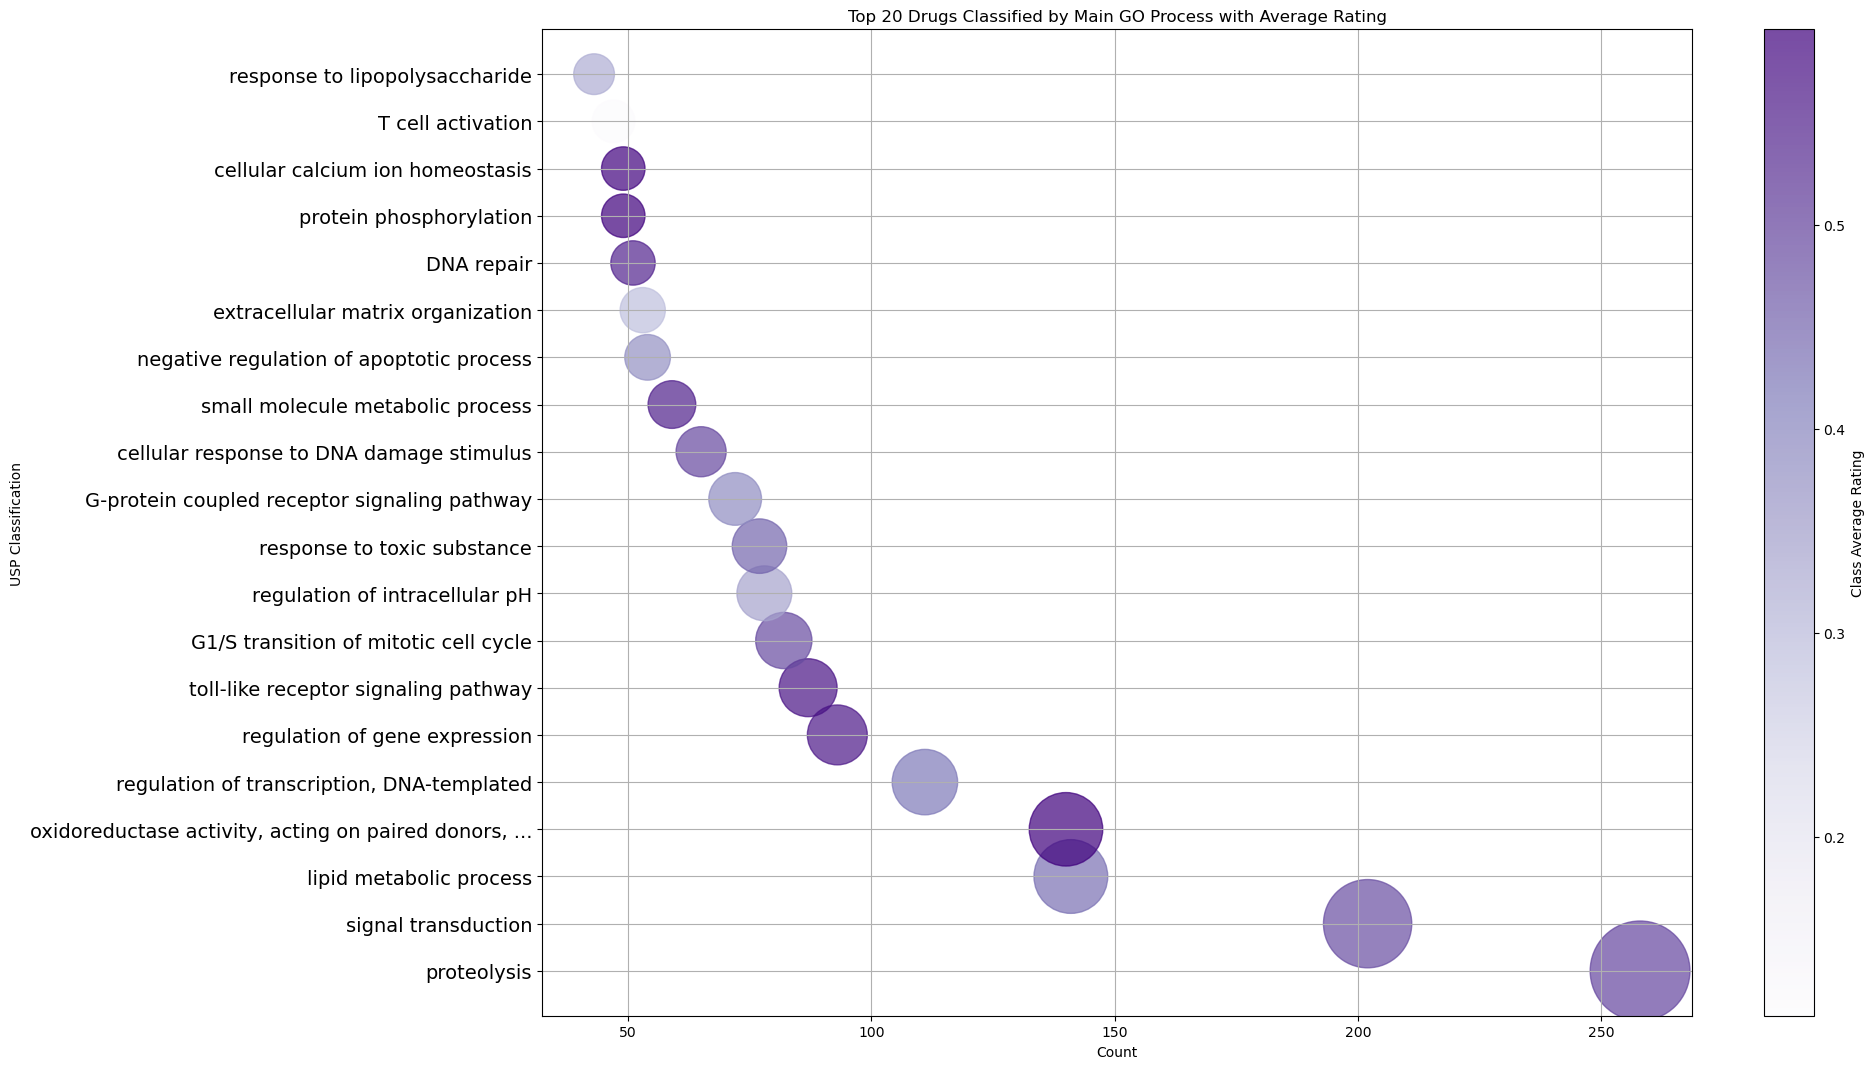

Exporting data to /Users/ricoandreschmitt/Code/GitHub/allmzheimer/plot_creation/drug_class_plot/test_top_20_usp_classifications_avg_rating.csv


In [7]:
import os
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import pandas as pd
from collections import defaultdict
from dotenv import load_dotenv
import numpy as np

# Load environment variables from .env file
load_dotenv()

# Get Neo4j connection details from environment variables
uri = os.getenv("uri")
user = os.getenv("username")
password = os.getenv("password")

# Function to get the counts and average ratings of USP_classification_0
def get_classification_data(uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    classification_data = defaultdict(lambda: {'count': 0, 'total_rating': 0.0})
    non_numeric_count = 0
    
    try:
        with driver.session() as session:
            result = session.run("""
                MATCH (d:Drug)
                WHERE d.USP_classification_0 IS NOT NULL 
                AND d.rating_0 IS NOT NULL
                AND d.rating_1 IS NOT NULL
                AND d.rating_2 IS NOT NULL
                AND d.rating_3 IS NOT NULL
                AND d.rating_4 IS NOT NULL
                AND d.rating_5 IS NOT NULL
                AND d.rating_6 IS NOT NULL
                AND d.rating_7 IS NOT NULL
                AND d.rating_8 IS NOT NULL
                AND d.rating_9 IS NOT NULL                 
                RETURN d.USP_classification_0 AS classification,
                d.rating_0 AS rating_0, d.rating_1 AS rating_1, 
                d.rating_2 AS rating_2, d.rating_3 AS rating_3, 
                d.rating_4 AS rating_4, d.rating_5 AS rating_5, 
                d.rating_6 AS rating_6, d.rating_7 AS rating_7, 
                d.rating_8 AS rating_8, d.rating_9 AS rating_9
            """)
            
            for record in result:
                classification = record["classification"]
                ratings = [record[f"rating_{i}"] for i in range(10)]

                # Filter out non-numeric ratings
                numeric_ratings = []
                for rating in ratings:
                    try:
                        numeric_ratings.append(float(rating)) # Convert to float if possible
                    except ValueError:
                        non_numeric_count += 1 # Counter for sanity check

                # Calculate average rating with applicable ratings
                if numeric_ratings:
                    drug_avg_rating = sum(numeric_ratings) / len(ratings) # Calculate average rating
                    classification_data[classification]['count'] += 1
                    classification_data[classification]['total_rating'] += drug_avg_rating
        
    finally:
        driver.close()

    print(f"Number of non-numeric ratings: {non_numeric_count}")
    
    # Convert to a list of dictionaries and calculate average ratings
    classification_list = []
    for classification, data in classification_data.items():
        class_avg_rating = data['total_rating'] / data['count']
        classification_list.append({
            "classification": classification,
            "count": data['count'],
            "class_avg_rating": class_avg_rating
        })
    
    return classification_list

# Get the classification data
classification_data = get_classification_data(uri, user, password)

# Convert to DataFrame and get the top 20 classifications
df = pd.DataFrame(classification_data)
df = df.sort_values(by="count", ascending=False).head(20)

# Normalize the average ratings for color mapping
norm = plt.Normalize(df['class_avg_rating'].min(), df['class_avg_rating'].max())
cmap = plt.colormaps['Purples']  # Use the 'Purples' colormap for a purple shade

# Adjust x positions to create more space between bubbles
x_positions = np.arange(len(df)) * 8  # Spread out bubbles more

# Function to truncate long labels and append "..." when necessary
def truncate_label(label, max_length=20):
    if len(label) > max_length:
        return label[:max_length] + "..."
    return label

# Apply the truncation function to the classification labels
df['truncated_classification'] = df['classification'].apply(lambda x: truncate_label(x, max_length=50))

# Plot the bubble chart with truncated labels
plt.figure(figsize=(20, 12))  # Increase figure size for more horizontal space

scatter = plt.scatter(df["count"], x_positions, 
                      s=df["count"]*20, c=df["class_avg_rating"], cmap=cmap, norm=norm, alpha=0.7)

# Update the y-axis labels to use the truncated versions
plt.yticks(x_positions, df["truncated_classification"], fontsize=14)
plt.ylabel("USP Classification")
plt.xlabel("Count")

plt.title("Top 20 Drugs Classified by Main GO Process with Average Rating")
plt.subplots_adjust(bottom=0.65)  # Adjust bottom margin to make room for x-axis labels
plt.colorbar(scatter, label='Class Average Rating')  # Add color bar to the side
plt.grid(True)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to give more space for x-axis labels

# Save the plot as a PNG file
output_directory = os.path.expanduser("/Users/ricoandreschmitt/Code/GitHub/allmzheimer/plot_creation/drug_class_plot")
os.makedirs(output_directory, exist_ok=True)
output_filepath = os.path.join(output_directory, "top_25_usp_classifications_avg_rating.png")
plt.savefig(output_filepath, dpi=800)

plt.show()

# export the data to a csv file
output_csv = os.path.join(output_directory, "test_top_20_usp_classifications_avg_rating.csv")
print(f"Exporting data to {output_csv}")    
df.to_csv(output_csv, index=False)
